# Detecção de Vivacidade (Liveness)

Os datasets para esse tema são bem grandes em tamanho, para garantir boa performance. Entretanto, não temos poder computacional nem de armazenamento para poder utilizá-los, então optamos por um dataset menor, assim como um modelo menor performático.

O dataset que gostaríamos de utilizar para garantir boa acurácia tinha 70GB, e o modelo que gostaríamos é o EfficientNetB7.

Entretanto, com nossos recursos, conseguimos utilizar um dataset do [Kaggle](https://www.kaggle.com/datasets/trainingdatapro/real-vs-fake-anti-spoofing-video-classification/data) com o modelo MobileNetV3Large.

In [1]:
import tensorflow
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Definir a seed para garantir reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
def setup_directories(base_dir, output_dir):
    """
    Creates the output directory structure for storing processed images.
    """
    os.makedirs(output_dir, exist_ok=True)
    real_output = os.path.join(output_dir, 'real_images')
    spoof_output = os.path.join(output_dir, 'spoof_images')
    os.makedirs(real_output, exist_ok=True)
    os.makedirs(spoof_output, exist_ok=True)
    return real_output, spoof_output

In [3]:
def split_data(video_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Splits video files into training, validation, and test sets.
    """
    video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
    random.shuffle(video_files)

    total_videos = len(video_files)
    train_split = int(total_videos * train_ratio)
    val_split = int(total_videos * val_ratio)

    train_videos = video_files[:train_split]
    val_videos = video_files[train_split:train_split + val_split]
    test_videos = video_files[train_split + val_split:]  # O restante vai para teste

    return train_videos, val_videos, test_videos


In [ ]:
def resize_with_padding(image, target_size=(224, 224)):
    """
    Redimensiona a imagem mantendo a proporção e adiciona padding para evitar distorções.
    
    Args:
        image (numpy array): Imagem a ser processada.
        target_size (tuple): Dimensão final da imagem (largura, altura).

    Returns:
        numpy array: Imagem redimensionada sem distorção.
    """
    h, w, _ = image.shape
    target_w, target_h = target_size

    # Calcula a escala para manter a proporção
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Redimensiona a imagem mantendo a proporção
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Cria uma nova imagem de fundo preto (ou branco se preferir)
    new_image = np.zeros((target_h, target_w, 3), dtype=np.uint8)  # Fundo preto
    # new_image[:] = (255, 255, 255)  # Alternativa: fundo branco

    # Centraliza a imagem redimensionada dentro do novo espaço
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    new_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

    return new_image

In [5]:
def extract_frames_from_videos(video_dir, output_dir, video_list, frame_interval=5):
    """
    Extracts frames from specified videos and saves them to the output directory.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for video_file in tqdm(video_list, desc=f"Processando videos em {video_dir}"):
        video_path = os.path.join(video_dir, video_file)
        
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Erro ao abrir video: {video_path}")
            continue

        frame_count = 0
        saved_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_count > 30 and frame_count % frame_interval == 0:
                base_name = os.path.splitext(video_file)[0]
                frame_filename = f"{base_name}_quadro{frame_count}.jpg"
                frame_path = os.path.join(output_dir, frame_filename)
                cv2.imwrite(frame_path, resize_with_padding(frame))
                saved_count += 1
            
            frame_count += 1

        cap.release()
        print(f"Vídeo processado {video_file}: {saved_count} quadros salvos.")

    print(f"Extração de quadros concluída. Quadros salvos em: {output_dir}")

In [6]:
def process_dataset(base_dir, output_dir, frame_interval=30):
    """
    Processes videos from the dataset and extracts frames for train, validation, and test sets.
    """
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    # Criar diretórios de saída
    train_real_output, train_spoof_output = setup_directories(train_dir, os.path.join(output_dir, 'train'))
    val_real_output, val_spoof_output = setup_directories(val_dir, os.path.join(output_dir, 'val'))
    test_real_output, test_spoof_output = setup_directories(test_dir, os.path.join(output_dir, 'test'))

    # Separar vídeos para cada conjunto
    real_video_dir = os.path.join(base_dir, 'train', 'real_video')
    attack_video_dir = os.path.join(base_dir, 'train', 'attack')
    
    real_train, real_val, real_test = split_data(real_video_dir)
    attack_train, attack_val, attack_test = split_data(attack_video_dir)

    # Processar vídeos de treino
    print("Processando dataset de treino...")
    extract_frames_from_videos(real_video_dir, train_real_output, real_train, frame_interval)
    extract_frames_from_videos(attack_video_dir, train_spoof_output, attack_train, frame_interval)

    # Processar vídeos de validação
    print("Processando dataset de validação...")
    extract_frames_from_videos(real_video_dir, val_real_output, real_val, frame_interval)
    extract_frames_from_videos(attack_video_dir, val_spoof_output, attack_val, frame_interval)

    # Processar vídeos de teste
    print("Processando dataset de teste...")
    extract_frames_from_videos(real_video_dir, test_real_output, real_test, frame_interval)
    extract_frames_from_videos(attack_video_dir, test_spoof_output, attack_test, frame_interval)

In [7]:
base_dir = 'C:/Users/Yago Angelini/OneDrive - Safe Design Art/MyFiles/FIAP/Computer Vision/Git/data/ProjetoFinal/Liveness_Dataset'  # Update this to your Kaggle dataset folder
output_dir = 'C:/Users/Yago Angelini/OneDrive - Safe Design Art/MyFiles/FIAP/Computer Vision/Git/data/ProjetoFinal/Liveness_Dataset/Processed'

In [8]:
# Train the model
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
val_dir = os.path.join(output_dir, 'val')

In [ ]:
# Preprocess the dataset
process_dataset(base_dir, output_dir, frame_interval=1)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback

class CustomCheckpoint(Callback):
    def __init__(self):
        super(CustomCheckpoint, self).__init__()
        self.best_score = -float("inf")  # Inicializa como o pior possível

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get("val_loss")
        val_accuracy = logs.get("val_accuracy")

        if val_loss is not None and val_accuracy is not None:
            score = val_accuracy / (val_loss + 1e-8)  # Fórmula de equilíbrio

            if score > self.best_score:
                self.best_score = score
                self.model.save_weights(f"val_accuracy {val_accuracy:.4f} e val_loss {val_loss:.4f}.h5")  # Salva os pesos
                print(f"\n✅ Melhor equilíbrio encontrado! Salvando modelo na época {epoch + 1}.")


def train_mobile_netv3_large(train_data_dir, val_data_dir, batch_size=32, epochs=10, model_save_path='mobilenetv3_large_liveness.h5'):
    """
    Train a MobileNetV3Large model for liveness detection.
    """

    train_datagen = ImageDataGenerator(
        rescale=1./255,  
        rotation_range=10,  # Reduzi a rotação para evitar distorções excessivas
        width_shift_range=0.15,  # Pequenos deslocamentos horizontais
        height_shift_range=0.15,  # Pequenos deslocamentos verticais
        shear_range=0.1,  # Reduzi a distorção para não alterar muito os objetos
        zoom_range=0.2,  # Mantive o zoom para simular diferentes distâncias da câmera
        horizontal_flip=True,  # Mantém espelhamento horizontal (ok para vídeos)
        brightness_range=[0.7, 1.3],  # Simula variações de iluminação
        channel_shift_range=30,  # Pequena alteração nos canais de cores
        preprocessing_function=lambda img: cv2.GaussianBlur(img, (3, 3), 0)  # Aplica leve desfoque
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(224, 224),  # Ensure it matches MobileNetV3Large input size
        batch_size=batch_size,
        class_mode='binary'
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(224, 224),  # Ensure it matches MobileNetV3Large input size
        batch_size=batch_size,
        class_mode='binary'
    )

    # Model architecture
    base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    # Criar os callbacks
    custom_checkpoint = CustomCheckpoint()
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)

    # Criar callback para salvar o modelo com a melhor acurácia de validação
    checkpoint = ModelCheckpoint(
        "best_accuracy.h5",  # Nome do arquivo salvo
        monitor="val_accuracy",  # Monitorar a acurácia na validação
        save_best_only=True,  # Salvar apenas quando melhorar
        mode="max",  # Maior valor de val_accuracy é melhor
        verbose=1  # Mostrar mensagem ao salvar
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_loss.h5', monitor='val_loss', save_best_only=True, mode="min", verbose=1),
        custom_checkpoint,
        reduce_lr
    ]

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[callbacks])

    # # Fase de fine-tuning: Descongelar as últimas 20 camadas do MobileNetV3Large
    # for layer in base_model.layers[-20:]:
    #     layer.trainable = True

    # # Recompilar com uma taxa de aprendizado menor
    # model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    # history = model.fit(train_generator, validation_data=val_generator, epochs=10)

    return model, history

In [11]:
model, history = train_mobile_netv3_large(train_dir, test_dir, batch_size=16, epochs=100)

Found 23034 images belonging to 2 classes.
Found 3044 images belonging to 2 classes.
Epoch 1/100
1440/1440 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.5569
Epoch 1: val_loss improved from inf to 0.65648, saving model to best_loss.h5

✅ Melhor equilíbrio encontrado! Salvando modelo na época 1.
1440/1440 [==============================] - 241s 165ms/step - loss: 0.6810 - accuracy: 0.5569 - val_loss: 0.6565 - val_accuracy: 0.5394 - lr: 1.0000e-04
Epoch 2/100
1440/1440 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.5983
Epoch 2: val_loss improved from 0.65648 to 0.64499, saving model to best_loss.h5

✅ Melhor equilíbrio encontrado! Salvando modelo na época 2.
1440/1440 [==============================] - 229s 159ms/step - loss: 0.6571 - accuracy: 0.5983 - val_loss: 0.6450 - val_accuracy: 0.7539 - lr: 1.0000e-04
Epoch 3/100
1440/1440 [==============================] - ETA: 0s - loss: 0.6374 - accuracy: 0.6273
Epoch 3: val_loss improved fro

## Teste e Validação em Tempo Real (Ao Vivo)

In [56]:
import tensorflow
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Definir a seed para garantir reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [65]:
def test_and_evaluate_model(model, test_data_dir, batch_size=1):
    """
    Test the trained model, display a confusion matrix, save the model, and return evaluation metrics.

    Args:
        model: Trained Keras model.
        test_data_dir: Directory containing test data.
        batch_size: Batch size for test data generator.
        model_save_path: Path to save the trained model.
    """
    # Data generator for test data
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(224, 224),  # Matches MobileNetV3Large input size
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False  # Ensure predictions align with labels
    )

    print(test_generator.class_indices)

    # Evaluate model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Predict labels for test data
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.35).astype(int).flatten()  # Threshold at 0.5

    # Confusion Matrix
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    cm = confusion_matrix(true_classes, predicted_classes, normalize='true')
    print("\nConfusion Matrix:")
    print(cm)

    # Classification Report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print("\nClassification Report:")
    print(report)

    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', values_format='.2f')
    plt.title("Confusion Matrix")
    plt.show()

    # Save the model
    # model.save(model_save_path)
    # print(f"Model saved to {model_save_path}")

    return test_loss, test_accuracy, cm, report

In [66]:
base_dir = 'C:/Users/Yago Angelini/OneDrive - Safe Design Art/MyFiles/FIAP/Computer Vision/Git/data/ProjetoFinal'  # Update this to your Kaggle dataset folder
output_dir = 'C:/Users/Yago Angelini/OneDrive - Safe Design Art/MyFiles/FIAP/Computer Vision/Git/data/ProjetoFinal/Liveness_Dataset/Processed'
val_dir = os.path.join(output_dir, 'val')
model_save_path = os.path.join(base_dir, 'best_model_val_accuracy 0.9067 e val_loss 0.3130.h5')

In [67]:
# Função para construir o modelo (arquitetura conforme seu código)
def build_model():
    base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Congela as camadas do modelo base
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [68]:
# Cria uma nova instância do modelo
model = build_model()

# Carrega os pesos do arquivo atual
model.load_weights(model_save_path)

Found 7893 images belonging to 2 classes.
{'real_images': 0, 'spoof_images': 1}
7893/7893 [==============================] - 60s 7ms/step - loss: 0.3587 - accuracy: 0.8471
Test Loss: 0.3587, Test Accuracy: 0.8471
7893/7893 [==============================] - 53s 7ms/step

Confusion Matrix:
[[0.87793757 0.12206243]
 [0.14081714 0.85918286]]

Classification Report:
              precision    recall  f1-score   support

 real_images       0.78      0.88      0.83      2851
spoof_images       0.93      0.86      0.89      5042

    accuracy                           0.87      7893
   macro avg       0.85      0.87      0.86      7893
weighted avg       0.87      0.87      0.87      7893



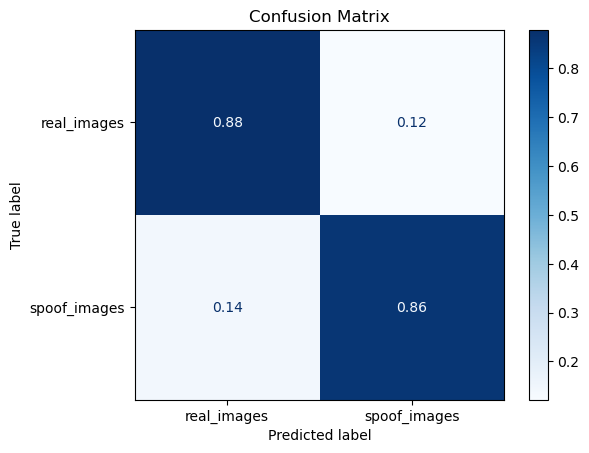

In [69]:
# Test the model and evaluate
test_loss, test_accuracy, cm, report = test_and_evaluate_model(
    model,  # Extract the model from the tuple
    test_data_dir=val_dir,
    batch_size=1
)

### Teste com Câmera (Ao Vivo)

In [ ]:
from tensorflow.keras.models import load_model

# Carrega o modelo salvo
# caminho_modelo = "C:/Users/Yago Angelini/OneDrive - Safe Design Art/MyFiles/FIAP/Computer Vision/Git/data/ProjetoFinal/Liveness_Dataset/mobilenetv3_liveness.h5"
# modelo = load_model(caminho_modelo)

# Define parametros de pre-processamento
tamanho_imagem = (224, 224)  # Deve ser o mesmo usado no treinamento
limiar = 0.35  # Threshold para classificar

# Inicia a captura de video (webcam)
captura = cv2.VideoCapture(0)

if not captura.isOpened():
    print("Erro ao abrir a camera.")
    exit()

print("Iniciando inferencia em tempo real. Pressione ESC para sair.")

while True:
    ret, quadro = captura.read()
    if not ret:
        print("Nao foi possivel capturar o quadro.")
        break

    # Redimensiona o quadro para o tamanho esperado pelo modelo
    quadro_redim = cv2.resize(quadro, tamanho_imagem)

    # Converte o quadro de BGR (OpenCV) para RGB
    quadro_rgb = cv2.cvtColor(quadro_redim, cv2.COLOR_BGR2RGB)

    # Normaliza os pixels para a faixa [0, 1]
    quadro_norm = quadro_rgb.astype("float32") / 255.0

    # Expande as dimensoes para criar um batch (1, altura, largura, canais)
    entrada = np.expand_dims(quadro_norm, axis=0)

    # Realiza a previsao
    predicao = model.predict(entrada)[0][0]

    confianca = predicao * 100 if predicao > limiar else (1 - predicao) * 100

    # Interpreta o resultado
    if predicao > limiar:
        texto = f"Fraude (Confianca: {confianca:.0f}%)"
        cor = (0, 0, 255)  # vermelho
    else:
        texto = f"Real (Confianca: {confianca:.0f}%)"
        cor = (0, 255, 0)  # verde

    # Exibe o texto no quadro
    cv2.putText(quadro, texto, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, cor, 2)

    # Mostra o quadro com a inferencia
    cv2.imshow("Deteccao de Liveness", quadro)

    # Encerra se a tecla ESC for pressionada
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Libera os recursos
captura.release()
cv2.destroyAllWindows()

Iniciando inferencia em tempo real. Pressione ESC para sair.
1/1 [==============================] - 0s 25ms/step
